In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
%reload_ext autoreload
%autoreload 2
import transformers
data_dir = "data/"
output_data_dir = "output_data/"
models_dir = "models/"
%pylab inline
pd.set_option('display.max_columns', 999)
import random
import time

Populating the interactive namespace from numpy and matplotlib


# Loading data

###  Independent variables

In [2]:
indep_df = pd.read_csv(data_dir + "independent_variables.csv")

In [3]:
indep_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
len(indep_df.id.drop_duplicates())/len(indep_df)

1

In [5]:
indep_df.set_index("id", inplace=True)

### Dependent variable

In [6]:
dep_df = pd.read_csv(data_dir + "dependent_variables.csv")

In [7]:
dep_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
dep_df.set_index("id", inplace=True)

In [9]:
len(indep_df)/float(len(dep_df))

1.0

# Preprocessing

###TODO

Missing values in construction year, populatoin

Clustering for latitude/longitude?

For categorical with many modes, add feature -> projection of mode in target space

In [10]:
indep_df.num_private.value_counts()

0       58643
6          81
1          73
5          46
8          46
32         40
45         36
15         35
39         30
93         28
3          27
7          26
2          23
65         22
47         21
102        20
4          20
17         17
80         15
20         14
25         12
11         11
41         10
34         10
16          8
120         7
150         6
22          6
12          5
24          5
        ...  
14          3
61          3
27          2
26          2
160         1
30          1
698         1
60          1
1402        1
450         1
668         1
131         1
35          1
672         1
42          1
136         1
87          1
300         1
280         1
141         1
62          1
111         1
240         1
1776        1
755         1
180         1
213         1
23          1
55          1
94          1
Name: num_private, dtype: int64

In [11]:
indep_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [12]:
indep_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [13]:
len(indep_df)

59400

In [15]:
preprocessing_pipeline = Pipeline([
        ("TimeStampConverter", transformers.TimeStampConverter(cols_to_convert=['date_recorded'], date_format="%Y-%m-%d")),
        ("TypeConverter", transformers.TypeConverter(cols_to_convert=['region_code', 'district_code'], final_type=object)),
        
        ("ReplaceValuesByNan", transformers.ReplaceValuesByNan(columns_to_transform=["population", "construction_year"])),
        ("NanIndicatorAdder", transformers.NanIndicatorAdder()),
        ("CategoricalFeatureImputer", transformers.CategoricalFeatureImputer()),
        ("DateInfoGetter", transformers.DateInfoGetter()),
        
        ("ClassifierProjectionFeature", transformers.ClassifierProjectionFeature(target_series=dep_df.status_group, 
                                                                                 projection_threshold=0.02)),
        ("ImputationByMedian", transformers.NumericalFeatureImputation(strategy="mean")),
        ("RareValuesRemover", transformers.RareValuesRemover(threshold=0.1)),
        ("Dummifier", transformers.Dummifier()),
        
        #("OutlierRemoval", transformers.OutlierRemoval(anomaly_threshold=0.8)),
        ("ConvertToNp", transformers.PandasDfToNpArrayConverter()),
        ("VarianceThreshold", VarianceThreshold(threshold=0.1)),
        ("StandardScaler", StandardScaler())
    ])
df_train, df_test, y_train, y_test = train_test_split(indep_df, dep_df, test_size=0.2)
print df_train.shape
print y_train.shape
print df_test.shape
print y_test.shape
x_train = preprocessing_pipeline.fit_transform(df_train, y_train.status_group)
#outlier_mask = preprocessing_pipeline.named_steps["OutlierRemoval"].outlier_mask
#print outlier_mask.sum()
#y_train = y_train_full.loc[outlier_mask, :]
features = preprocessing_pipeline.named_steps["ConvertToNp"].features[
    preprocessing_pipeline.named_steps["VarianceThreshold"].get_support()]

(47520, 39)
(47520, 1)
(11880, 39)
(11880, 1)
Starting method transform of class TimeStampConverter
Method transform of class TimeStampConverter took 0.0370571613312 seconds to perform
Starting method transform of class TypeConverter
Method transform of class TypeConverter took 0.0138998031616 seconds to perform
Starting method transform of class ReplaceValuesByNan
Method transform of class ReplaceValuesByNan took 0.0779600143433 seconds to perform
Starting method transform of class NanIndicatorAdder
Method transform of class NanIndicatorAdder took 0.0674839019775 seconds to perform
Starting method transform of class CategoricalFeatureImputer
Method transform of class CategoricalFeatureImputer took 0.140209913254 seconds to perform
Starting method transform of class DateInfoGetter
Method transform of class DateInfoGetter took 1.33063292503 seconds to perform
Starting method fit of class ClassifierProjectionFeature
Method fit of class ClassifierProjectionFeature took 1.2729780674 second

In [16]:
print [x for x in features if "target" in x]
print [x for x in features if "count" in x]

['subvillage_target_response', 'wpt_name_target_response']
['extraction_type_class_count', 'extraction_type_count', 'extraction_type_group_count', 'funder_count', 'installer_count', 'lga_count', 'management_count', 'management_group_count', 'payment_count', 'payment_type_count', 'quality_group_count', 'quantity_count', 'quantity_group_count', 'region_count', 'scheme_management_count', 'scheme_name_count', 'source_class_count', 'source_count', 'source_type_count', 'subvillage_count', 'ward_count', 'water_quality_count', 'waterpoint_type_count', 'waterpoint_type_group_count', 'wpt_name_count']


In [18]:
x_test = preprocessing_pipeline.transform(df_test)
#outlier_mask = preprocessing_pipeline.named_steps["OutlierRemoval"].outlier_mask
#print outlier_mask.sum()
#y_test = y_test_full.loc[outlier_mask, :]

Starting method transform of class TimeStampConverter
Method transform of class TimeStampConverter took 0.00916910171509 seconds to perform
Starting method transform of class TypeConverter
Method transform of class TypeConverter took 0.00375318527222 seconds to perform
Starting method transform of class ReplaceValuesByNan
Method transform of class ReplaceValuesByNan took 0.0189821720123 seconds to perform
Starting method transform of class NanIndicatorAdder
Method transform of class NanIndicatorAdder took 0.0304939746857 seconds to perform
Starting method transform of class CategoricalFeatureImputer
Method transform of class CategoricalFeatureImputer took 0.0464971065521 seconds to perform
Starting method transform of class DateInfoGetter
Method transform of class DateInfoGetter took 0.387317180634 seconds to perform
Starting method transform of class ClassifierProjectionFeature
Method transform of class ClassifierProjectionFeature took 0.523505926132 seconds to perform
Starting method

In [19]:
preprocessing_pipeline.named_steps.keys()

['RareValuesRemover',
 'NanIndicatorAdder',
 'VarianceThreshold',
 'ConvertToNp',
 'Dummifier',
 'CategoricalFeatureImputer',
 'ClassifierProjectionFeature',
 'ReplaceValuesByNan',
 'DateInfoGetter',
 'TypeConverter',
 'ImputationByMedian',
 'StandardScaler',
 'TimeStampConverter']

In [20]:
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(47520, 104)
(47520, 1)
(11880, 104)
(11880, 1)


In [21]:
x_train.dump(output_data_dir + "train_data_with_variance_threshold.dump")
x_test.dump(output_data_dir + "test_data_without_variance_threshold.dump")
y_train.to_csv(output_data_dir + "train_target.csv")
y_test.to_csv(output_data_dir + "test_target.csv")


In [22]:
joblib.dump(preprocessing_pipeline, 
            models_dir + "pipeline.dump", compress=1)

PicklingError: Can't pickle <function <lambda> at 0x7f4c6cf2c578>: it's not found as transformers.<lambda>

In [3]:
x_train1 = np.load("train_data_with_variance_threshold.dump")
x_train2 = np.load("train_data_without_variance_threshold.dump")
x_test1 = np.load("test_data_with_variance_threshold.dump")
x_test2 = np.load("test_data_without_variance_threshold.dump")
y_train = pd.read_csv("target_train_data.csv")
y_test = pd.read_csv("target_test_data.csv")
dep_df = pd.read_csv("target.csv")

# Visualization

/home/vlandeau/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


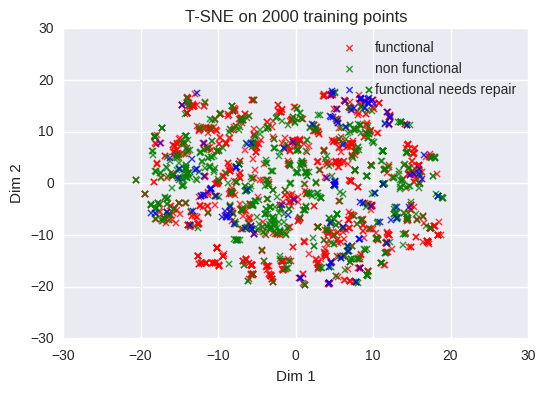

In [23]:
n_points = 2000
perplexity = 25

sample_index = random.sample(range(len(y_train)),n_points)
X_tsne = TSNE(perplexity=perplexity).fit_transform(x_train[sample_index])
y_tsne = y_train.status_group.as_matrix()[sample_index]

plt.figure()
colors = ['g', 'b', 'r']
for value in dep_df.status_group.unique():
    plt.scatter(X_tsne[np.where(y_tsne == value), 0],
                       X_tsne[np.where(y_tsne == value), 1],
                       marker='x', color=colors.pop(randint(len(colors))),
                       linewidth='1', alpha=0.8, label=value)

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE on %d training points' % n_points)
plt.legend(loc='best')
plt.show()

# Model fitting

In [78]:
preprocessing_pipeline = Pipeline([
        ("TimeStampConverter", transformers.TimeStampConverter(cols_to_convert=['date_recorded'], date_format="%Y-%m-%d")),
        ("TypeConverter", transformers.TypeConverter(cols_to_convert=['region_code', 'district_code'], final_type=object)),
        
        ("ReplaceValuesByNan", transformers.ReplaceValuesByNan(columns_to_transform=["population", "construction_year"])),
        ("NanIndicatorAdder", transformers.NanIndicatorAdder()),
        ("CategoricalFeatureImputer", transformers.CategoricalFeatureImputer()),
        ("DateInfoGetter", transformers.DateInfoGetter())
  ])

model_pipeline = Pipeline([
        ("ClassifierProjectionFeature", transformers.ClassifierProjectionFeature(target_series=dep_df.status_group,
                                                                                 projection_threshold=0.1)),
        ("ImputationByMedian", transformers.NumericalFeatureImputation(strategy="median")),
        ("RareValuesRemover", transformers.RareValuesRemover(threshold=0.01)),
        ("Dummifier", transformers.Dummifier()),
        ("ConvertToNp", transformers.PandasDfToNpArrayConverter()),
        ("VarianceThreshold", VarianceThresholdXY(threshold=0.05)),
        ("StandardScaler", StandardScaler()),
        ('RF', RandomForestClassifier())])
df_train, df_test, y_train, y_test = train_test_split(indep_df, dep_df, test_size=0.2)
x_train = preprocessing_pipeline.fit_transform(df_train)
x_test = preprocessing_pipeline.transform(df_test)

Starting method transform of class TimeStampConverter
Method transform of class TimeStampConverter took 0.0336380004883 seconds to perform
Starting method transform of class TypeConverter
Method transform of class TypeConverter took 0.0103640556335 seconds to perform
Starting method transform of class ReplaceValuesByNan
Method transform of class ReplaceValuesByNan took 0.083683013916 seconds to perform
Starting method transform of class NanIndicatorAdder
Method transform of class NanIndicatorAdder took 0.0662219524384 seconds to perform
Starting method transform of class CategoricalFeatureImputer
Method transform of class CategoricalFeatureImputer took 0.169059991837 seconds to perform
Starting method transform of class DateInfoGetter
Method transform of class DateInfoGetter took 1.47035884857 seconds to perform
Starting method transform of class TimeStampConverter
Method transform of class TimeStampConverter took 0.0155758857727 seconds to perform
Starting method transform of class Ty

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "ClassifierProjectionFeature__projection_threshold": np.linspace(0.01, 0.2, 20),
    "ClassifierProjectionFeature__target_series": [dep_df.status_group],
    "ImputationByMedian__strategy": ["mean", "median"],
    "RareValuesRemover__threshold": np.linspace(0.1, 0.3, 21),
    "VarianceThreshold__threshold": np.linspace(0.1, 0.3, 21),
    "RF__n_estimators": range(250, 650, 50)
}
randomized_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dist,
                                      n_jobs=4, n_iter=16)

randomized_search.fit(x_train, y_train.status_group)

In [83]:
randomized_search.best_params_

{'ClassifierProjectionFeature__projection_threshold': 0.02,
 'ClassifierProjectionFeature__target_series': id
 69572                 functional
 8776                  functional
 34310                 functional
 67743             non functional
 19728                 functional
 9944                  functional
 19816             non functional
 54551             non functional
 53934             non functional
 46144                 functional
 49056                 functional
 50409                 functional
 36957                 functional
 50495                 functional
 53752                 functional
 61848                 functional
 48451             non functional
 58155             non functional
 34169    functional needs repair
 18274                 functional
 48375                 functional
 6091                  functional
 58500    functional needs repair
 37862                 functional
 51058                 functional
 22308    functional needs repair
 55012

In [77]:
randomized_search.best_params_

{'ImputationByMedian__strategy': 'mean',
 'RF__n_estimators': 350,
 'RareValuesRemover__threshold': 0.16,
 'VarianceThreshold__threshold': 0.18000000000000002}

In [62]:
print x_train1.shape
print x_test1.shape

(47520, 114)
(11880, 114)


In [ ]:

start_time = time.time()

gbm = GradientBoostingClassifier(learning_rate=0.1, loss='deviance',
              max_depth=None, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=7, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=350)

gbm.fit(x_train1, y_train.status_group)

y_test_pred = gbm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred1)

print "elapsed time: " + str(time.time() - start_time)

In [ ]:
gbm.score(x_test1, y_test)

In [ ]:
importances = pd.DataFrame({"features": features, "importance": rf1.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

In [35]:
start_time = time.time()

rf = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=450,
                            n_jobs=4)

rf.fit(x_train, y_train.status_group)

y_test_pred = rf.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

ValueError: Found arrays with inconsistent numbers of samples: [ 4051 11880]

In [37]:
rf.score(x_test, y_test)

ValueError: Found arrays with inconsistent numbers of samples: [ 4051 11880]

In [65]:
rf1.score(x_test1, y_test)

0.77171717171717169

In [66]:
importances = pd.DataFrame({"features": features, "importance": rf1.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

,features,importance
2,longitude,0.070970
3,latitude,0.069277
89,quantity_group_dry,0.061086
85,quantity_dry,0.058218
8,construction_year,0.044986
113,date_recorded_since_beginning,0.044266
1,gps_height,0.039465
7,population,0.029384
110,date_recorded_weekday,0.024789
109,waterpoint_type_group_other,0.021701


In [25]:
start_time = time.time()

rf2 = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=300,
                            n_jobs=4)

rf2.fit(x_train, y_train.status_group)

y_test_pred = rf2.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5400  126  910]
 [ 534  195  169]
 [1407   33 3106]]
elapsed time: 17.1001861095


In [26]:
rf2.score(x_test, y_test)

0.7324074074074074

In [16]:
y_train.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'], dtype=object)

In [24]:
dict_replace = {
    'functional': 1,
    'non functional': 0,
    'functional needs repair': -1
}
y_array = y_train.status_group.replace(dict_replace).as_matrix()
y_array_test = y_test.status_group.replace(dict_replace).as_matrix()

In [30]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=60, n_jobs=4)

knn.fit(x_train, y_train.status_group)

y_test_pred = knn.predict(x_test)
print confusion_matrix(y_true=y_test.status_group, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5682   54  700]
 [ 604  118  176]
 [1622   38 2886]]
elapsed time: 85.210547924


In [31]:
print knn.score(x_test, y_test.status_group)

0.731144781145


In [35]:
print knn.score(x_test, y_test.status_group)

0.717845117845


In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=150,
                            n_jobs=4)

rf2.fit(x_train2, y_train.status_group)

y_test_pred2 = rf2.predict(x_test2)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred2)

print "elapsed time: " + str(time.time() - start_time)

#### TODO

Try KNN

Try stacking

In [37]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

knn = KNeighborsClassifier(n_jobs=4)

param_dist = {'n_neighbors': sp_randint(5, 150),
             'weights': ['uniform', 'distance'],
             'p': [1, 2]}

# run randomized search
n_iter_search = 20
random_search_knn = RandomizedSearchCV(knn, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                  n_jobs=4)

random_search_knn.fit(x_train1, y_array)

y_test_pred = random_search_knn.predict(x_test1)
print confusion_matrix(y_true=y_array_test, y_pred=y_test_pred)
print random_search_knn.score(x_test1, y_array_test)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

[[ 131  155  589]
 [  38 3034 1556]
 [  71  575 5731]]
0.748821548822
elapsed time: 9408.45386291


In [39]:
random_search_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=35, p=1,
           weights='distance')

In [38]:
start_time = time.time()

rf = RandomForestClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                  n_jobs=4)

random_search.fit(x_train1, y_train.status_group)

y_test_pred = random_search.predict(x_test1)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

ValueError: Can't handle mix of unknown and multiclass

In [40]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=355, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
importances = pd.DataFrame({"features": features, "importance": random_search.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

NameError: name 'features' is not defined

In [42]:
start_time = time.time()

gbm = GradientBoostingClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              #"loss": ["ls", "lad", "huber", "quantile"],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500)}

# run randomized search
n_iter_search = 20
random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search_gbm.fit(x_train1, y_train.status_group)

NameError: name 'x_test' is not defined

In [44]:
y_test_pred = random_search_gbm.predict(x_test1)
print confusion_matrix(y_true=y_array_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

ValueError: Mix of label input types (string and number)

In [26]:
random_search_gbm.score(x_test1, y_test)

0.80572390572390573

In [45]:
random_search_gbm.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=347,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
importances = pd.DataFrame({"features": features, "importance": random_search_gbm.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

,features,importance
2,longitude,0.277025
3,latitude,0.221642
112,date_recorded_since_beginning,0.113343
1,gps_height,0.075606
8,funder_OTHER,0.036063
109,date_recorded_weekday,0.033973
5,population,0.033667
83,quality_group_salty,0.018050
6,construction_year,0.012990
10,installer_OTHER,0.012351


In [46]:
start_time = time.time()

svm = SVC()

param_dist = {
    "C": [2**x for x in range(-5, 8, 1)],
    "gamma": [2**x for x in range(-5, 8, 1)]
}

# run randomized search
n_iter_search = 20
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4)

random_search_svm.fit(x_train1, y_train.status_group)

y_test_pred = random_search_svm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

NameError: name 'x_test' is not defined

In [51]:
y_test_pred = random_search_svm.predict(x_test1)
print confusion_matrix(y_true=y_test.status_group, y_pred=y_test_pred)

[[5467   40  870]
 [ 663    6  206]
 [1641   19 2968]]


In [52]:
random_search_svm.best_estimator_

SVC(C=64, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.03125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
start_time = time.time()

svm0 = SVC(C=65, gamma=0.03)
svm1 = SVC(C=60, gamma=0.03)

gbm0 = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=345,
              presort='auto', random_state=None, subsample=1.0)
gbm1 = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=350,
              presort='auto', random_state=None, subsample=1.0)
knn0 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=35, p=1,
           weights='distance')
knn1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=30, p=1,
           weights='distance')
knn2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=40, p=1,
           weights='distance')
rf0 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=355, n_jobs=4)
rf1 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=4)
rf2 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=360, n_jobs=4)

vc = VotingClassifier(estimators=[("svm0", svm0),
                                  ("svm1", svm1),
                                  ("gbm0", gbm0), 
                                  ("gbm1",gbm1),
                                  ("rf0", rf0),
                                 ("rf1", rf1),
                                 ("rf2", rf2),
                                 ('knn0', knn0),
                                 ('knn1', knn1),
                                 ('knn2', knn2)],
                     weights=[3] * 4 + [2] * 6)

vc.fit(x_train1, y_array)

y_test_pred = vc.predict(x_test1)
print confusion_matrix(y_true=y_array_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[ 100  129  646]
 [  24 3198 1406]
 [  29  460 5888]]
elapsed time: 51048.8278091


In [56]:
vc.score(x_test1, y_array_test)

0.77323232323232327

In [59]:
from sklearn.externals import joblib
joblib.dump(vc, 'models/voting_classifier.dump')

['models/voting_classifier.dump',
 'models/voting_classifier.dump_01.npy',
 'models/voting_classifier.dump_02.npy',
 'models/voting_classifier.dump_03.npy',
 'models/voting_classifier.dump_04.npy',
 'models/voting_classifier.dump_05.npy',
 'models/voting_classifier.dump_06.npy',
 'models/voting_classifier.dump_07.npy',
 'models/voting_classifier.dump_08.npy',
 'models/voting_classifier.dump_09.npy',
 'models/voting_classifier.dump_10.npy',
 'models/voting_classifier.dump_11.npy',
 'models/voting_classifier.dump_12.npy',
 'models/voting_classifier.dump_13.npy',
 'models/voting_classifier.dump_14.npy',
 'models/voting_classifier.dump_15.npy',
 'models/voting_classifier.dump_16.npy',
 'models/voting_classifier.dump_17.npy',
 'models/voting_classifier.dump_18.npy',
 'models/voting_classifier.dump_19.npy',
 'models/voting_classifier.dump_20.npy',
 'models/voting_classifier.dump_21.npy',
 'models/voting_classifier.dump_22.npy',
 'models/voting_classifier.dump_23.npy',
 'models/voting_classif

# Apply to competition data

In [60]:
comp_data = pd.read_csv("data/test_set.csv")

In [61]:
comp_data.shape

(14850, 40)